# ST 790 Project

## 1. Data Loading and Summary

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [18]:
# Setting Path
path = '/Users/miaoyu/Dropbox/ST790--001/790Project_Yiran_Miao/data'
os.chdir(path)

In [42]:
# Loading Data
data = pd.read_csv("train.csv")
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [20]:
# Summary of Data
print('Dimension of the data: {}'.format(data.shape))
print('Column name of the data: {}'.format(data.columns))
print('Total number of question pairs: {}'.format(len(data)))
print('Duplicate pairs: {}%'.format(round(data['is_duplicate'].mean()*100, 2)))
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Total number of questions in the data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Dimension of the data: (404290, 6)
Column name of the data: Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')
Total number of question pairs: 404290
Duplicate pairs: 36.92%
Total number of questions in the data: 537933
Number of questions that appear multiple times: 111780


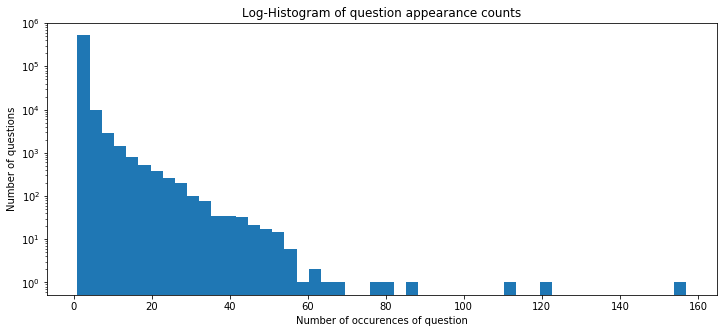

In [21]:
#Plot the Occurrence of Each Question
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

(-0.5, 1439.5, 1079.5, -0.5)

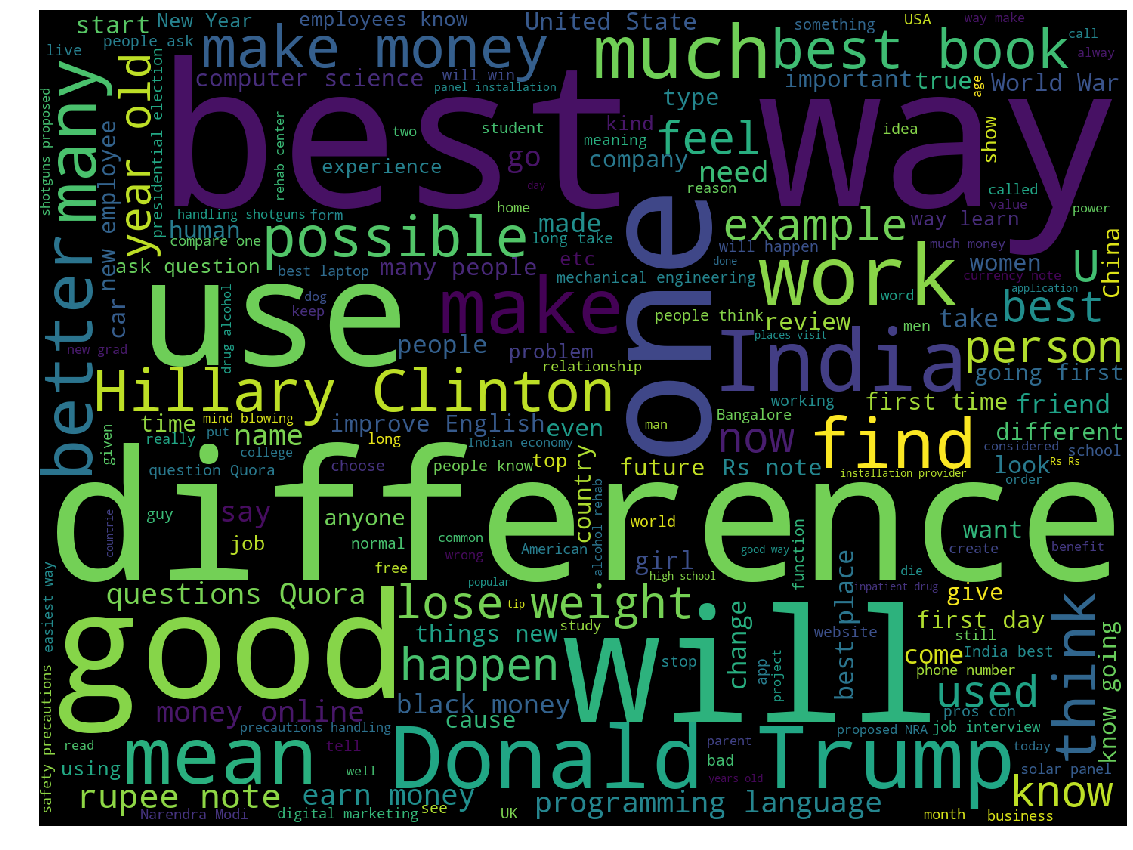

In [24]:
from wordcloud import WordCloud
data_qs = pd.Series(data['question1'].tolist() + data['question2'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080).generate(" ".join(data_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.savefig("WordCloud_before", dpi=300)
plt.axis('off')

In [25]:
#Check for null values
data.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [26]:
data[data.isnull().values==True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [43]:
data['question1']=data['question1'].fillna('null') #将data中"question1"所有空值赋值为'null'
data=data[~data['question1'].isin(['null'])]   #去掉有空值的sample
data['question2']=data['question2'].fillna('null') #将data中"question2"所有空值赋值为'null'
data=data[~data['question2'].isin(['null'])]   #去掉有空值的sample

In [44]:
len(data)

404287

## 2. Data Preprocessing

In [29]:
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_punctuation
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem.porter import *
#nltk.download('wordnet')

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text))
def preprocess(text):
    result = []
    # replace punctuation with space
    strip_punctuation(text) 
    # simple_preprocess() returns the token
    tokens = simple_preprocess(text)
    # lower capitalization
    tokens_lower = [word.lower() for word in tokens]
    if len(tokens_lower) <= 1:
        return None
    for token in tokens_lower:
        # remove stopwords and word with length less than 3
        if token not in STOPWORDS and len(token) >= 3:
            # lemmatize and stem
            result.append(lemmatize_stemming(token))
    if len(result) == 0:
        return text
    else:
        return ' '.join(result)

In [30]:
# An example
sentence = "Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success."
print('Preprocessed sentence is: ', preprocess(sentence))

Preprocessed sentence is:  python intellig work python python way success


In [31]:
print('Original sentence is: ', sentence)

Original sentence is:  Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success.


In [32]:
#Preprocessing the data
processed_data = data.copy()
processed_data['question1'] = processed_data['question1'].apply(preprocess)
processed_data['question2'] = processed_data['question2'].apply(preprocess)

In [33]:
processed_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guid invest share market india,step step guid invest share market,0
1,1,3,4,stori kohinoor koh noor diamond,happen indian govern stole kohinoor koh noor d...,0
2,2,5,6,increas speed internet connect vpn,internet speed increas hack dns,0
3,3,7,8,mental lone solv,remaind math math divid,0
4,4,9,10,dissolv water quik sugar salt methan carbon oxid,fish surviv salt water,0


In [34]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


(-0.5, 1439.5, 1079.5, -0.5)

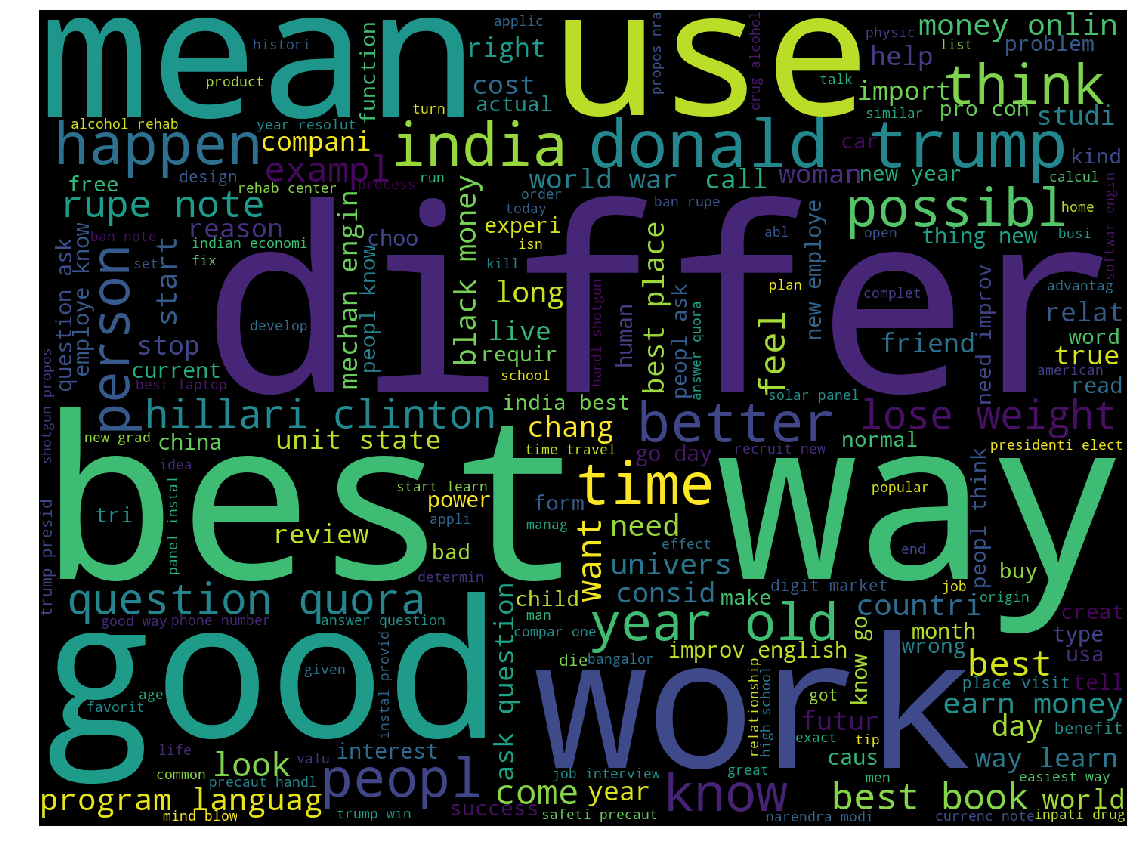

In [35]:
processed_data_qs = pd.Series(processed_data['question1'].tolist() + processed_data['question2'].tolist()).astype(str)
cloud = WordCloud(width=1440, height=1080).generate(" ".join(processed_data_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.savefig("WordCloud_after", dpi=300)
plt.axis('off')

In [36]:
#Check for null values
processed_data.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [37]:
processed_data[processed_data.isnull().values==True]

,id,qid1,qid2,question1,question2,is_duplicate
3306,3306,6553,6554,None,cornel endow lowest ivi leagu,0
13016,13016,25026,25027,None,work googl,0
17682,17682,33561,33562,None,websit suitabl download ebook lectur,0
20072,20072,37898,37899,solv,None,0
20794,20794,39204,39205,None,gmail tech support help phone number,0
23305,23305,33561,43661,None,best websit download newli publish book ebook,0
23884,23884,44699,44700,None,What is hh?,0
25228,25228,47035,47036,None,indian donald trump presid,0
25315,25315,47198,29712,None,kind question quora aren quora polici question...,0
31239,31239,57607,57608,None,math math,0


In [38]:
processed_data['question1']=processed_data['question1'].fillna('null') #将data中"question1"所有空值赋值为'null'
processed_data=processed_data[~processed_data['question1'].isin(['null'])]   #去掉有空值的sample
processed_data['question2']=processed_data['question2'].fillna('null') #将data中"question2"所有空值赋值为'null'
processed_data=processed_data[~processed_data['question2'].isin(['null'])]   #去掉有空值的sample

In [46]:
len(processed_data)

404174

In [47]:
index = processed_data.index.values
data = data.loc[index]
len(data)

404174

In [48]:
#Spliting Data into Training and Test Data
df_train, df_test = train_test_split(data, train_size=0.8, random_state=790)
print('Total number of question pairs: {}'.format(len(data)))
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs: 404174
Total number of question pairs for training: 323339
Total number of question pairs for testing: 80835


/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


mean-train 59.82 std-train 31.89 mean-test 59.85 std-test 32.22 max-train 1169.00 max-test 1169.00


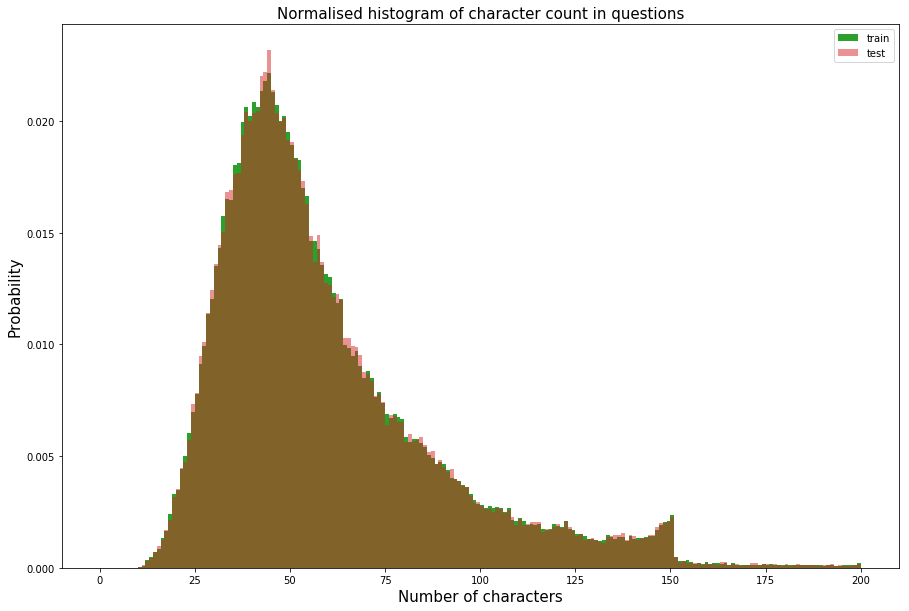

In [49]:
#Visualizing the distribution for character counts of each question in both training and test data
import seaborn as sns
pal = sns.color_palette()
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[3], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


mean-train 11.07 std-train 5.88 mean-test 11.07 std-test 5.93 max-train 237.00 max-test 237.00


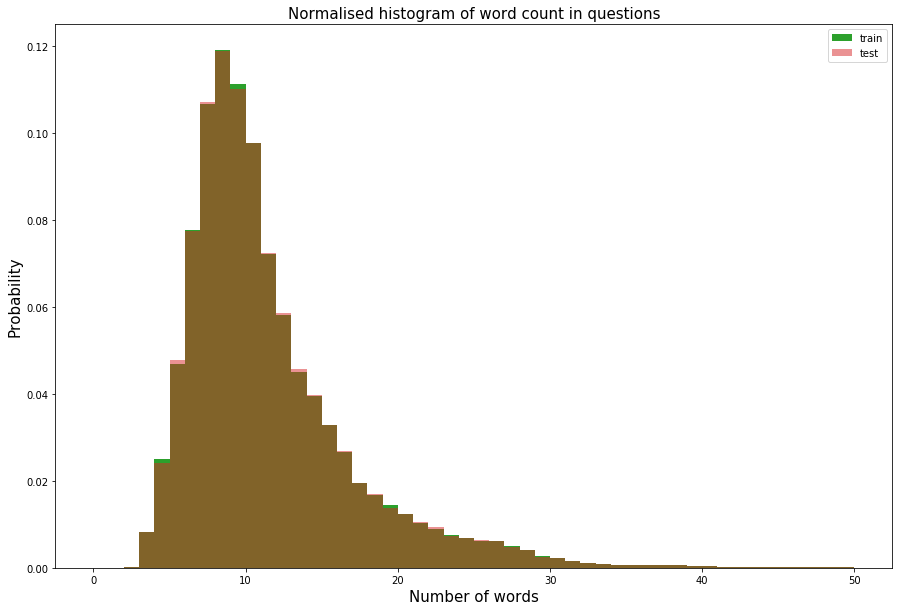

In [50]:
#Visualizing the distribution for word counts of each question in both training and test data
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[3], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

In [162]:
data.loc[16]['question2']

'What does manipulation means?'

In [159]:
processed_data.loc[16]['question1']

'manipul mean'

## 3. Word2Vec

In [51]:
import spacy

In [52]:
# if you cannot run the following code, try "python -m spacy download en_core_web_lg" in the terminal
nlp = spacy.load('/Users/miaoyu/anaconda3/lib/python3.7/site-packages/en_core_web_lg/en_core_web_lg-2.2.5')
#import en_core_web_lg
#nlp = en_core_web_lg.load()

In [53]:
# An example
dog = nlp.vocab["dog"]
cat = nlp.vocab["cat"]
dog.similarity(cat)

0.8016855

In [54]:
def word_vec_avg(text):
    """
    计算一句话中的所有词向量的平均值
    :param text: 向量 text containg clean tokens 
    :return: embd_avg
    """
    embedding = np.array([])
    word_list = []
    # ignore existed word
    for token in text:
        if not(token in word_list):
            word_list.append(token)
    # word2vec
    for word in word_list:
        embedding = np.append(embedding, nlp.vocab[word].vector)
    # reshape
    embedding = embedding.reshape(len(word_list), -1) # dim = (word_num, 300)
    embd_avg = np.mean(embedding, axis = 0)
    return(embd_avg)

def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

def word2vec(row):
    """
    Wrapper
    :row: a row of training data
    :return: similiarity
    """
    vector_a = word_vec_avg(row["question1"].split())
    vector_b = word_vec_avg(row["question2"].split())
    return cos_sim(vector_a, vector_b)
    
### 然后利用余弦相似度度量或者Minkowski，欧几里得距离等等
### https://www.zhihu.com/question/29978268 可求加权平均
### https://zhuanlan.zhihu.com/p/35093355

In [60]:
# An example
k = 0
text1 =processed_data.loc[k]['question1'].split()
print(text1)
vector1 = word_vec_avg(text1)
text2 = processed_data.loc[k]['question2'].split()
print(text2)
vector2 = word_vec_avg(text2)
print('The similarity is: ', cos_sim(vector1, vector2))
print('The true label is: ', processed_data['is_duplicate'][k])

['step', 'step', 'guid', 'invest', 'share', 'market', 'india']
['step', 'step', 'guid', 'invest', 'share', 'market']
The similarity is:  0.974822730678507
The true label is:  0


In [61]:
# Actually, there is only one word difference between them 
print(text2)
data.loc[k]['question2']

['step', 'step', 'guid', 'invest', 'share', 'market']


'What is the step by step guide to invest in share market?'

In [62]:
print(text1)
data.loc[k]['question1']

['step', 'step', 'guid', 'invest', 'share', 'market', 'india']


'What is the step by step guide to invest in share market in india?'

In [63]:
word2vec(processed_data.loc[0])

0.974822730678507

In [64]:
word_vec_feature = processed_data.apply(word2vec, axis = 1)

In [67]:
word_vec_feature.tail()

404285    0.946792
404286    0.933375
404287    1.000000
404288    0.695186
404289    1.000000
dtype: float64

In [68]:
len(word_vec_feature)

404174

## 4. LDA - TOPIC MODEL

In [69]:
# https://mp.weixin.qq.com/s/VJpp2wYW0vaCay2xxHrxTA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [70]:
def clean_sentence(text):
    """
    将 clean tokens 重组为句子
    :param text: 向量 clean tokens
    :return: "".join(sentence)
    """
    sentence = []
    for word in text:
        sentence.append(word)
        sentence.append(" ")
    return("".join(sentence))

In [71]:
def lda_distance(text1, text2):
    """
    计算 LDA similarity
    :param text1: 向量 clean tokens from question 1
    :param text2: 向量 clean tokens from question 2
    :return: difference between vectors of probability of topic
    """
    corpus = []
    corpus.append(clean_sentence(text1))
    corpus.append(clean_sentence(text2))
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(corpus)
    # topic number and seeds
    lda = LDA(n_topics = 2, random_state = 110)
    docres = lda.fit_transform(tfidf_matrix)
    return(np.linalg.norm(docres[0]-docres[1]))

In [72]:
def lda(row):
    """
    Wrapper
    :row: a row of training data
    :return difference between vectors of probability of topic
    """
    text1 = row["question1"].split()
    text2 = row["question2"].split()
    return lda_distance(text1, text2)

In [73]:
#An example
lda(processed_data.loc[0])

0.0074446554631735495

In [74]:
lda_feature = processed_data.apply(lda, axis=1, raw=True)

In [99]:
lda_feature.tail()

404285    8.336925e-07
404286    7.051148e-01
404287    0.000000e+00
404288    1.034561e+00
404289    0.000000e+00
dtype: float64

In [76]:
len(lda_feature)

404174

## 5. Shared Ngrams

In [77]:
#http://www.albertauyeung.com/post/generating-ngrams-python/
import re
from collections import Counter

In [78]:
def generate_ngrams(text, n):
    """
    Generate ngrams
    :text: 向量 text containg clean tokens
    :n: length of grams
    :return: a list of ngrams for text
    """
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[text[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [79]:
def grams_match_share(row, n=1):
    """
    Compute the proportion of shared ngrams
    :row: a row of training data
    :n: length of grams
    :return: proportion of shared ngrams
    """
    q1grams = Counter(generate_ngrams(row['question1'].split(), n))
    q2grams = Counter(generate_ngrams(row['question2'].split(), n))
   
    if len(q1grams) == 0 or len(q2grams) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_grams_in_q1 = [gram for gram in q1grams.keys() if gram in q2grams]
    shared_grams_in_q2 = [gram for gram in q2grams.keys() if gram in q1grams]
    R = (len(shared_grams_in_q1) + len(shared_grams_in_q2))/(len(q1grams) + len(q2grams))
    return R

In [80]:
#An example
processed_data.loc[0]['question1']

'step step guid invest share market india'

In [81]:
processed_data.loc[0]['question2']

'step step guid invest share market'

In [82]:
generate_ngrams(processed_data.loc[0]['question1'].split(), 2)

['step step',
 'step guid',
 'guid invest',
 'invest share',
 'share market',
 'market india']

In [83]:
generate_ngrams(processed_data.loc[0]['question2'].split(), 2)

['step step', 'step guid', 'guid invest', 'invest share', 'share market']

In [84]:
grams_match_share(processed_data.loc[0], n=2)

0.9090909090909091

### 5.1 N=1: Shared Words

In [85]:
gram1 = processed_data.apply(grams_match_share, axis=1, n=1, raw=True)

/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


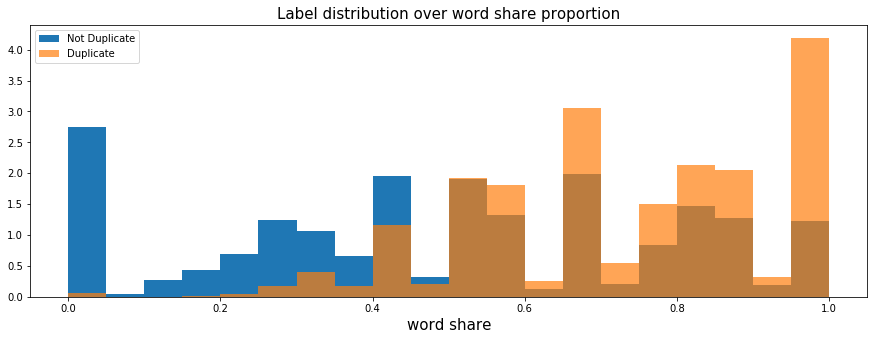

In [100]:
plt.figure(figsize=(15, 5))
plt.hist(gram1[processed_data['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(gram1[processed_data['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word share proportion', fontsize=15)
plt.xlabel('word share', fontsize=15)
plt.savefig('shared_word', dpi=300)

In [101]:
gram1.tail()

404285    0.833333
404286    0.666667
404287    1.000000
404288    0.000000
404289    1.000000
dtype: float64

In [102]:
len(gram1)

404174

### 5.2 N=2, 3: Shared Grams

In [89]:
gram2 = processed_data.apply(grams_match_share, axis=1, n=2, raw=True)

/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


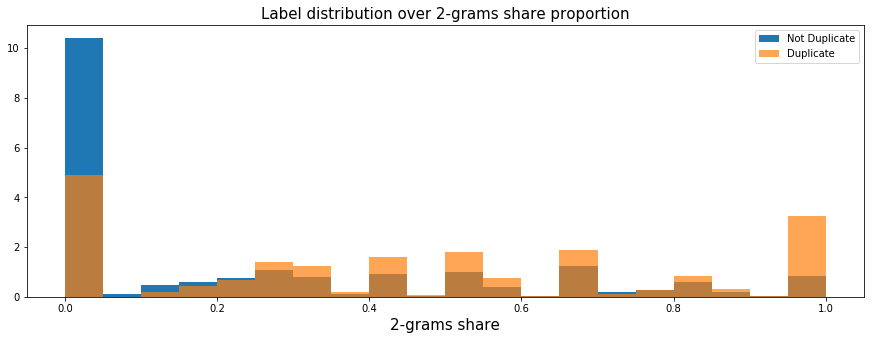

In [103]:
plt.figure(figsize=(15, 5))
plt.hist(gram2[processed_data['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(gram2[processed_data['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over 2-grams share proportion', fontsize=15)
plt.xlabel('2-grams share', fontsize=15)
plt.savefig('shared_2grams', dpi=300)

In [104]:
gram2.tail()

404285    0.6
404286    0.5
404287    0.0
404288    0.0
404289    1.0
dtype: float64

In [105]:
len(gram2)

404174

In [106]:
gram3 = processed_data.apply(grams_match_share, axis=1, n=3, raw=True)

/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/miaoyu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 24.0, 'word share')

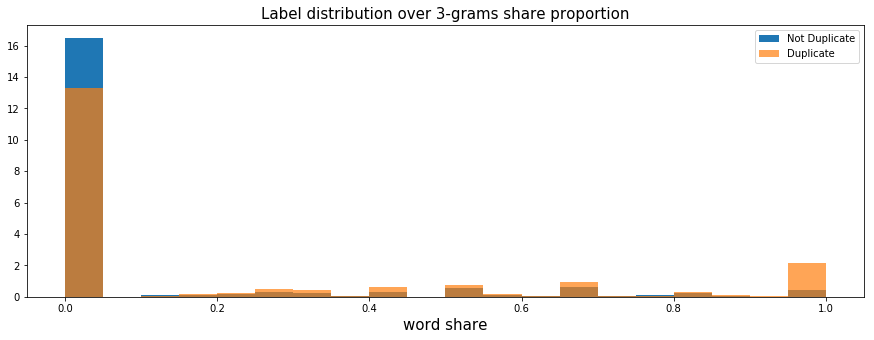

In [107]:
plt.figure(figsize=(15, 5))
plt.hist(gram3[processed_data['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(gram3[processed_data['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over 3-grams share proportion', fontsize=15)
plt.savefig('3_grams_share', dpi=300)
plt.xlabel('word share', fontsize=15)

In [109]:
gram3.tail()

404285    0.5
404286    0.0
404287    0.0
404288    0.0
404289    1.0
dtype: float64

In [110]:
len(gram3)

404174

## 6. Length and Diffrence Length for Question Pairs 

### 6.1 Length and Difference Length for Original Data

In [95]:
orgi_length1 = data.apply(lambda row: len(row['question1'].split(' ')), axis=1, raw=True)
orgi_length2 = data.apply(lambda row: len(row['question2'].split(' ')), axis=1, raw=True)
orgi_diff_length = orgi_length1 - orgi_length2

In [96]:
orgi_diff_length.tail()

404285    1
404286   -1
404287    1
404288   -8
404289   -2
dtype: int64

In [97]:
len(orgi_diff_length)

404174

### 6.2 Length and Difference Length for Processed Data

In [111]:
pro_length1 = processed_data.apply(lambda row: len(row['question1'].split(' ')), axis=1, raw=True)
pro_length2 = processed_data.apply(lambda row: len(row['question2'].split(' ')), axis=1, raw=True)
pro_diff_length = pro_length1 - pro_length2

In [112]:
pro_diff_length.tail()

404285    0
404286    0
404287    0
404288   -4
404289    0
dtype: int64

In [113]:
len(pro_diff_length)

404174

### 6.3 Length and Difference of Unique Words for Processed Data

In [114]:
uni_length1 = processed_data.apply(lambda row: len(np.unique(row['question1'].split(' '))), axis=1, raw=True)
uni_length2 = processed_data.apply(lambda row: len(np.unique(row['question2'].split(' '))), axis=1, raw=True)
uni_diff_length = uni_length1 - uni_length2

In [115]:
uni_diff_length.tail()

404285    0
404286    0
404287    0
404288   -4
404289    0
dtype: int64

In [116]:
len(uni_diff_length)

404174

## 7. Summary Statistics

### 7.1 Number of Capital Letters

In [117]:
caplett_num1 = data.apply(lambda row: len([w for w in row['question1'] if w.isupper()]), axis=1, raw=True)
caplett_num2 = data.apply(lambda row: len([w for w in row['question2'] if w.isupper()]), axis=1, raw=True)
caplett_diff = caplett_num1 - caplett_num2

In [118]:
caplett_diff.tail()

404285   -5
404286    0
404287    0
404288    2
404289    0
dtype: int64

In [119]:
len(caplett_diff)

404174

### 7.2 Number of Words with All Captial Letters 

In [121]:
capwordall_num1 = data.apply(lambda row: len([w for w in row['question1'].split() if w.isupper()]), axis=1, raw=True)
capwordall_num2 = data.apply(lambda row: len([w for w in row['question2'].split() if w.isupper()]), axis=1, raw=True)
capwordall_diff = capwordall_num1 - capwordall_num2

In [123]:
capwordall_diff.tail()

404285   -1
404286    0
404287    0
404288   -2
404289    0
dtype: int64

In [124]:
len(capwordall_diff)

404174

### 7.3 Number of Words with Captitalized First Letters

In [125]:
capword_num1 = data.apply(lambda row: sum([w[0].isupper() for w in row['question1'].split()]), axis=1, raw=True)
capword_num2 = data.apply(lambda row: sum([w[0].isupper() for w in row['question2'].split()]), axis=1, raw=True)
capword_diff = capword_num1 - capword_num2

In [126]:
capword_diff.tail()

404285   -2
404286    0
404287    0
404288    0
404289    0
dtype: int64

In [127]:
len(capword_diff)

404174

### 7.4 Whether there is Math or not

In [128]:
math1 = data.apply(lambda row: '[math]' in row['question1'], axis=1, raw=True)
math2 = data.apply(lambda row: '[math]' in row['question2'], axis=1, raw=True)

In [129]:
math1.tail()

404285    False
404286    False
404287    False
404288    False
404289    False
dtype: bool

In [130]:
len(math1)

404174

### 7.5 Number of Digits

In [131]:
dig1 = data.apply(lambda row: sum([w.isdigit() for w in row['question1']]), axis=1, raw=True)
dig2 = data.apply(lambda row: sum([w.isdigit() for w in row['question2']]), axis=1, raw=True)
dig_diff = dig1 - dig2

In [132]:
dig_diff.tail()

404285    0
404286    0
404287    0
404288    0
404289    0
dtype: int64

In [133]:
len(dig_diff)

404174

### 7.6 Number of Question Marks

In [135]:
qm1 = data.apply(lambda row: len([w for w in row['question1'] if w=="?"]), axis=1, raw=True)
qm2 = data.apply(lambda row: len([w for w in row['question2'] if w=="?"]), axis=1, raw=True)
qm_diff = qm1 - qm2

In [136]:
qm_diff.tail()

404285    0
404286    0
404287    0
404288    0
404289    0
dtype: int64

In [137]:
len(qm_diff)

404174

## 8. Aggregate Functions to Create Features

In [139]:
result = [word_vec_feature, lda_feature, gram1, gram2, gram3, orgi_length1, orgi_length2, orgi_diff_length, pro_length1, pro_length2, pro_diff_length, 
          uni_length1, uni_length2, uni_diff_length, caplett_num1, caplett_num2, caplett_diff, capwordall_num1, capwordall_num2, capwordall_diff, 
          capword_num1, capword_num2, capword_diff, math1, math2, dig1, dig2, dig_diff, qm1, qm2, qm_diff]
names = ['word_vec', 'lda', 'gram1', 'gram2', 'gram3', 'orgi_length1', 'orgi_length2', 'orgi_diff_length', 'pro_length1', 'pro_length2', 'pro_diff_length', 
          'uni_length1', 'uni_length2', 'uni_diff_length', 'caplett_num1', 'caplett_num2', 'caplett_diff', 'capwordall_num1', 'capwordall_num2', 'capwordall_diff', 
          'capword_num1', 'capword_num2', 'capword_diff', 'math1', 'math2', 'dig1', 'dig2', 'dig_diff', 'qm1', 'qm2', 'qm_diff']
feature = pd.concat(result, axis=1, names=names)

In [140]:
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.974823,0.007445,0.909091,0.909091,0.888889,14,12,2,7,6,...,1,0,False,False,0,0,0,1,1,0
1,0.890409,0.842271,0.615385,0.545455,0.444444,8,13,-5,5,8,...,3,0,False,False,0,0,0,1,1,0
2,0.941350,0.000028,0.600000,0.000000,0.000000,14,10,4,5,5,...,3,0,False,False,0,0,0,1,1,0
3,0.537349,0.002280,0.000000,0.000000,0.000000,11,9,2,3,4,...,1,3,False,True,0,8,-8,2,1,1
4,0.883384,0.899935,0.333333,0.000000,0.000000,13,7,6,8,4,...,1,0,False,False,0,0,0,1,1,0


In [141]:
lable =  processed_data["is_duplicate"]

In [143]:
lable.tail()

404285    0
404286    1
404287    0
404288    0
404289    0
Name: is_duplicate, dtype: int64

In [144]:
len(lable)

404174

In [145]:
data_new = pd.concat([feature, lable], axis=1)

In [146]:
data_new.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,is_duplicate
0,0.974823,0.007445,0.909091,0.909091,0.888889,14,12,2,7,6,...,0,False,False,0,0,0,1,1,0,0
1,0.890409,0.842271,0.615385,0.545455,0.444444,8,13,-5,5,8,...,0,False,False,0,0,0,1,1,0,0
2,0.941350,0.000028,0.600000,0.000000,0.000000,14,10,4,5,5,...,0,False,False,0,0,0,1,1,0,0
3,0.537349,0.002280,0.000000,0.000000,0.000000,11,9,2,3,4,...,3,False,True,0,8,-8,2,1,1,0
4,0.883384,0.899935,0.333333,0.000000,0.000000,13,7,6,8,4,...,0,False,False,0,0,0,1,1,0,0


In [147]:
data_new.shape

(404174, 32)

In [93]:
data_new.to_csv("data_new.csv")